In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
import re

In [3]:
from sklearn.metrics  import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [4]:
#Set plots to display in jupyter notebooks
%matplotlib inline

## Read in the data and plot the category counts

In [5]:
#read in the huffpost article dataset (json file)
df =  pd.read_json("data/news-category-dataset/News_Category_Dataset_v2.json", lines =  True)

In [6]:
df1 =  pd.read_json("data/news-category-dataset/news_category_dataset.json", lines =  True)

In [7]:
df.shape

(200853, 6)

In [8]:
df.head()

,authors,category,date,headline,link,short_description
0,Melissa Jeltsen,CRIME,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...
1,Andy McDonald,ENTERTAINMENT,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.
2,Ron Dicker,ENTERTAINMENT,2018-05-26,Hugh Grant Marries For The First Time At Age 57,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...
3,Ron Dicker,ENTERTAINMENT,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...
4,Ron Dicker,ENTERTAINMENT,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ..."


In [9]:
df.dtypes

authors                      object
category                     object
date                 datetime64[ns]
headline                     object
link                         object
short_description            object
dtype: object

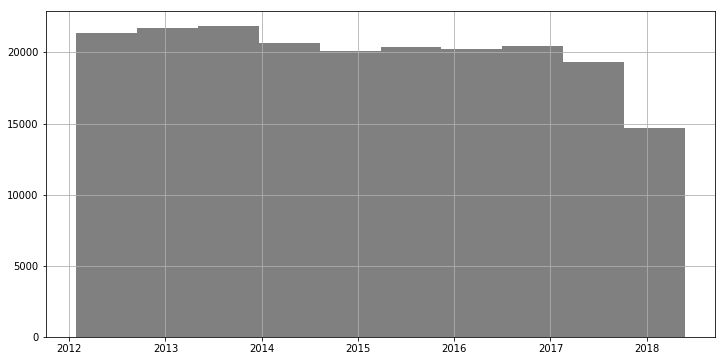

In [10]:
#Plot the data by date
df.date.hist(figsize = (12,6), color = 'grey')

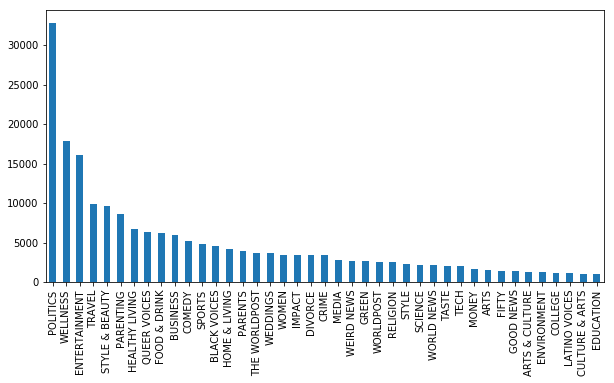

In [11]:
#Bar plot of the labels by category 
categoryCount = df['category'].value_counts()
categoryCount.plot.bar(figsize = (10,5))

#### Combine description and headline into a single field for classification

In [12]:
def tokenize_url(url):
    #remove huffpost portion
    url = url.replace("https://www.huffingtonpost.com/entry/","")
    #use regular expression to convert underscore into a space
    url = re.sub("(\W|_)+"," ",url)
    return url

In [13]:
df['tokenized_url'] = df['link'].apply(lambda x:tokenize_url(x))

#description + headline
df['text_desc_headline'] = df['short_description'] + ' '+ df['headline']

#description + headline + url
df['desc_headline_url'] =  df['text_desc_headline'] + ' ' + df['tokenized_url']

## Extract features 3 different ways: by word presence, word count, and by TF-IDF score

In [14]:
# Initiate logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

def extract_features(df, field, training_data, testing_data, type = "binary"):
    """Extract features using one of three different methods"""
    
    logging.info("Extracting features and creating vocabulary...")
    
    if type == "binary":
        # BINARY FEATURE REPRESENTATION
        
        #Ignore terms that are in more than 95% of documents
        cv= CountVectorizer(binary=True, max_df=0.95)
        #Create dictionary from words to integer ids
        cv.fit_transform(training_data[field].values)
        
        train_feature_set=cv.transform(training_data[field].values)
        test_feature_set=cv.transform(testing_data[field].values)
        
        return train_feature_set, test_feature_set, cv
    
    elif type == "counts":
        # COUNT BASED FEATURE REPRESENTATION
        
        #Ignore terms that are in more than 95% of documents
        cv= CountVectorizer(binary=False, max_df=0.95)
        #Create dictionary from words to integer ids
        cv.fit_transform(training_data[field].values)
        
        train_feature_set=cv.transform(training_data[field].values)
        test_feature_set=cv.transform(testing_data[field].values)
        
        return train_feature_set, test_feature_set, cv
     
    elif  type == "tfidf":
        # TF-IDF BASED FEATURE REPRESENTATION
        logging.info("tfidf transformation")
        #Ignore terms that are in more than 95% of documents
        tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_df=0.95)
        #Create dictionary from words to integer ids
        tfidf_vectorizer.fit_transform(training_data[field].values)
        
        train_feature_set=tfidf_vectorizer.transform(training_data[field].values)
        test_feature_set=tfidf_vectorizer.transform(testing_data[field].values)
        
        return train_feature_set, test_feature_set, tfidf_vectorizer
    
    else:
        logging.info("incorrect type")
        return;

In [16]:
def compute_accuracy(Y_labels, Y_preds):
    '''Compute the accuracy of Y_preds on Y_labels'''
    correct = 0 
    total = len(Y_labels)
    
    for i in range(0, total):
        if Y_labels[i] ==  Y_preds[i]:
            correct = correct + 1
     
    return correct/total

In [17]:
def compute_recall(Y_labels, Y_preds, mean = True):
    '''Function to manually compute recall for each class
    If mean == False, it returns a dataframe containing each classes recall, 
    otherwise it returns the arithmetic average of each class recall.
    '''
    labels = list(set(Y_preds))
    label_count = len(labels)
    true_pos = np.zeros(label_count)
    false_neg = np.zeros(label_count)
 
    #Iterate over each label, counting true positives and false positives
    for j in range(0,label_count):
        for i in range(0,len(Y_preds)):
            #If label should be predicted
            if Y_labels[i] == labels[j]:
                #True positive
                if Y_preds[i] == labels[j]:
                    true_pos[j] = true_pos[j]+1
                #False Negative
                else:
                    false_neg[j] = false_neg[j] + 1
    
    # compute the recall for each class
    recall = true_pos/(false_neg +true_pos)
    
    #Return the mean of each labels recall
    if mean == True:
        return sum(recall)/label_count
    #Return dataframe with class labels and their recall values
    else:
        return pd.DataFrame({'Labels':labels,'Recall':recall})

In [18]:
def compute_precision(Y_labels, Y_preds, mean = True):
    '''Function to manually compute precision for each class
    If mean == False, it returns a dataframe containing each classes precision, 
    otherwise it returns the arithmetic average of each class precision.
    '''
    labels = list(set(Y_preds))
    label_count = len(labels)
    true_pos = np.zeros(label_count)
    false_pos = np.zeros(label_count)
 
    #Iterate over each label, counting true positives and false positives
    for j in range(0,label_count):
        for i in range(0,len(Y_preds)):
            #If label is predicted
            if Y_preds[i] == labels[j]:
                #True positive
                if Y_labels[i] == labels[j]:
                    true_pos[j] = true_pos[j]+1
                #False Positive
                else:
                    false_pos[j] = false_pos[j] + 1
    
    # compute the recall for each class
    precision = true_pos/(false_pos+true_pos)
    
    #Return the mean of each labels recall
    if mean == True:
        return sum(precision)/label_count
    #Return dataframe with class labels and their recall values
    else:
        return pd.DataFrame({'Labels':labels,'Precision':precision})

In [19]:
def compute_f1(Y_labels, Y_preds, mean = True):
    '''Manually computes the f1 score for each class.
    If mean == False, it returns a dataframe containing each classes f1 score, 
    otherwise it returns the arithmetic average of each class f1.
    '''
    
    recall = compute_recall(Y_labels, Y_preds, False)
    precision = compute_precision(Y_labels, Y_preds, False)
    
    #Combine recall and precision dataframes
    f1 = pd.merge(recall, precision)
    
    #Add new column for f1 score
    f1['f1'] =  2*f1['Precision']*f1['Recall']/(f1['Precision']+f1['Recall'])
    
    #Return harmonic mean of precision and recall
    if mean == True:
        return sum(f1['f1'])/len(f1.index)
    #Return dataframe with class labels and their precision, recall, and f1 scores
    else:
        return f1

In [20]:
#Double check recall, precision, and f1 working correctly
from sklearn.metrics import f1_score
#f1_score(Y_test, preds_test, average = 'macro')
from sklearn.metrics import recall_score
#recall_score(Y_test, preds_test, average = 'macro')
from sklearn.metrics import precision_score
#precision_score(Y_test, preds_test, average = 'macro')

In [21]:
def train_model(df, field = 'short_description', feature_rep = 'binary', max_iterations =1000):
    ''''''
    logging.info("Starting model training...")
    
    # Get a train-test split with a preset random seed
    training_data, testing_data = train_test_split(df, random_state = 1000)
    
    # Get the labels as an array
    Y_train = training_data['category'].values
    Y_test = testing_data['category'].values
    
    # Get the features using our function extract_features
    X_train, X_test, feature_transformer = extract_features(df, field, training_data, testing_data, type = feature_rep)
    
    #Initialize logistic Regression classifier using sklearn
    logging.info("Training a Logistic Regression Model...")
    scikit_log_reg = LogisticRegression(verbose = 1, solver = 'liblinear', random_state = 0, C = 5, penalty = 'l2', max_iter = max_iterations) 
    model = scikit_log_reg.fit(X_train, Y_train)
    logging.info('Model fit complete.') 
    
    #Get predictions for test set
    test_preds = model.predict(X_test)
    
    logging.info('Starting Evaluation...')
    accuracy = compute_accuracy( Y_test, test_preds)
    f1_score = compute_f1(Y_test, test_preds, False)
    
    logging.info("Done training and evaluation.")
    return model, feature_transformer, accuracy, f1_score

In [172]:
#training_data, testing_data = train_test_split(df, random_state = 1000)

# Get the labels as an array
#Y_train = training_data['category'].values
#Y_test = testing_data['category'].values

# Get the features using our function extract_features
#X_train, X_test, feature_transformer = extract_features(df, field, training_data, testing_data, type = feature_rep)

#Initialize logistic Regression classifier using sklearn
#logging.info("Training a Logistic Regression Model...")
#scikit_log_reg = LogisticRegression(verbose = 1, solver = 'liblinear', random_state = 0, C = 5, penalty = 'l2', max_iter = max_iterations) 
#model = scikit_log_reg.fit(X_train, Y_train)
#logging.info('Model fit complete.') 

2020-04-18 20:57:03,002 : INFO : Extracting features and creating vocabulary...
2020-04-18 20:57:08,135 : INFO : Training a Logistic Regression Model...


[LibLinear]

2020-04-18 21:02:53,178 : INFO : Model fit complete.


In [186]:
 #Get predictions for test set
#test_preds = model.predict(X_test)
    
#logging.info('Starting Evaluation...')
#accuracy = compute_accuracy( Y_test, test_preds)
#f1_score = compute_f1(Y_test, test_preds)

2020-04-18 21:18:20,029 : INFO : Starting Evaluation...


In [188]:
#f1_score

0.27990836933190194

# Train a single Model

### Model 1 - Binary Features with description only 

In [176]:
field = 'short_description'
feature_rep = 'binary'    

model, transformer, accuracy, f1 = train_model(df, field, feature_rep)

2020-04-18 21:05:08,847 : INFO : Starting model training...
2020-04-18 21:05:08,916 : INFO : Extracting features and creating vocabulary...
2020-04-18 21:05:14,010 : INFO : Training a Logistic Regression Model...


[LibLinear]

2020-04-18 21:11:01,366 : INFO : Model fit complete.
2020-04-18 21:11:01,416 : INFO : Starting Evaluation...
2020-04-18 21:11:02,061 : INFO : Done training and evaluation.


In [183]:
print("\n Accuracy = {0}; f1 = {1}".format(accuracy, sum(f1['f1'])/len(f1.index)))


 Accuracy = 0.4160592663400645; f1 = 0.27990836933190194


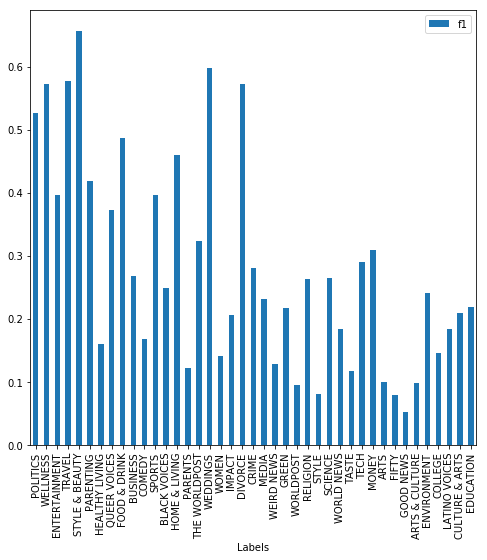

In [216]:
#Convert categoryCount to a Dataframe for merging
category_count = pd.DataFrame({'Labels': categoryCount.index, 'Count': categoryCount.values}) 

#Merge the f1 and category_count dataframes
f1_count_df = pd.merge(f1, category_count)

#Order the dataframe by the article count for plotting
f1_count_df = f1_count_df.sort_values(by='Count', ascending = False)

#Plot the f1 score, ordered from most to least prevalent categories
f1_count_df.plot(kind='bar', x ='Labels', y = 'f1', figsize=(8,8))

## Model 2 - TF-IDF with description only

In [16]:
field = 'short_description'
feature_rep = 'tfidf'    

model, transformer, accuracy, f1 = train_model(df, field, feature_rep)

2020-04-18 21:55:54,292 : INFO : Starting model training...
2020-04-18 21:55:54,348 : INFO : Extracting features and creating vocabulary...
2020-04-18 21:55:54,348 : INFO : tfidf transformation
2020-04-18 21:55:59,268 : INFO : Training a Logistic Regression Model...


[LibLinear]

2020-04-18 21:57:27,231 : INFO : Model fit complete.
2020-04-18 21:57:27,281 : INFO : Starting Evaluation...
2020-04-18 21:57:27,777 : INFO : Done training and evaluation.


In [17]:
print("\n Accuracy = {0}; f1 = {1}".format(accuracy, sum(f1['f1'])/len(f1.index)))


 Accuracy = 0.4509698490460828; f1 = 0.29887128995941925


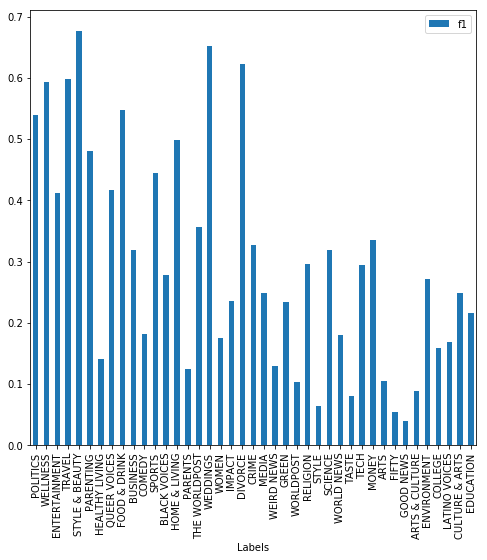

In [18]:
#Convert categoryCount to a Dataframe for merging
category_count = pd.DataFrame({'Labels': categoryCount.index, 'Count': categoryCount.values}) 

#Merge the f1 and category_count dataframes
f1_count_df = pd.merge(f1, category_count)

#Order the dataframe by the article count for plotting
f1_count_df = f1_count_df.sort_values(by='Count', ascending = False)

#Plot the f1 score, ordered from most to least prevalent categories
f1_count_df.plot(kind='bar', x ='Labels', y = 'f1', figsize=(8,8))

## Model 3 - TF-IDF  with description, headline

In [20]:
field = 'text_desc_headline'
feature_rep = 'tfidf'    

model, transformer, accuracy, f1 = train_model(df, field, feature_rep)

2020-04-18 22:02:59,747 : INFO : Starting model training...
2020-04-18 22:02:59,857 : INFO : Extracting features and creating vocabulary...
2020-04-18 22:02:59,858 : INFO : tfidf transformation
2020-04-18 22:03:07,052 : INFO : Training a Logistic Regression Model...


[LibLinear]

2020-04-18 22:04:46,408 : INFO : Model fit complete.
2020-04-18 22:04:46,467 : INFO : Starting Evaluation...
2020-04-18 22:04:47,024 : INFO : Done training and evaluation.


In [21]:
print("\n Accuracy = {0}; f1 = {1}".format(accuracy, sum(f1['f1'])/len(f1.index)))


 Accuracy = 0.6143904090492691; f1 = 0.48654564980132997


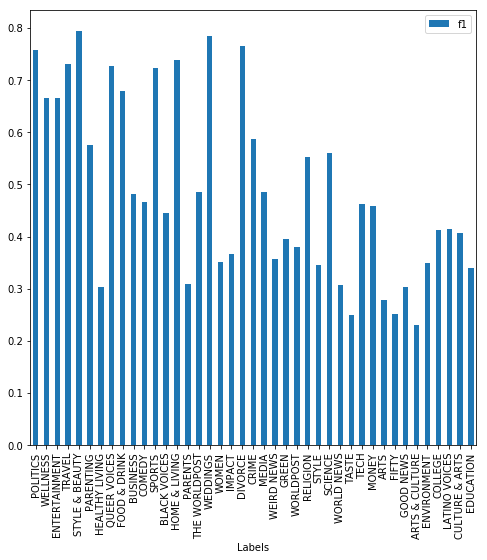

In [22]:
#Convert categoryCount to a Dataframe for merging
category_count = pd.DataFrame({'Labels': categoryCount.index, 'Count': categoryCount.values}) 

#Merge the f1 and category_count dataframes
f1_count_df = pd.merge(f1, category_count)

#Order the dataframe by the article count for plotting
f1_count_df = f1_count_df.sort_values(by='Count', ascending = False)

#Plot the f1 score, ordered from most to least prevalent categories
f1_count_df.plot(kind='bar', x ='Labels', y = 'f1', figsize=(8,8))

## Model 4 - TF-IDF with url, headline, and description

In [39]:
field = 'desc_headline_url'
feature_rep = 'tfidf'    

model, transformer, accuracy, f1 = train_model(df, field, feature_rep)

2020-04-18 22:13:19,730 : INFO : Starting model training...
2020-04-18 22:13:19,870 : INFO : Extracting features and creating vocabulary...
2020-04-18 22:13:19,871 : INFO : tfidf transformation
2020-04-18 22:13:29,065 : INFO : Training a Logistic Regression Model...


[LibLinear]

2020-04-18 22:15:16,725 : INFO : Model fit complete.
2020-04-18 22:15:16,792 : INFO : Starting Evaluation...
2020-04-18 22:15:17,256 : INFO : Done training and evaluation.


In [40]:
print("\n Accuracy = {0}; f1 = {1}".format(accuracy, sum(f1['f1'])/len(f1.index)))


 Accuracy = 0.6672043653164456; f1 = 0.558007056329061


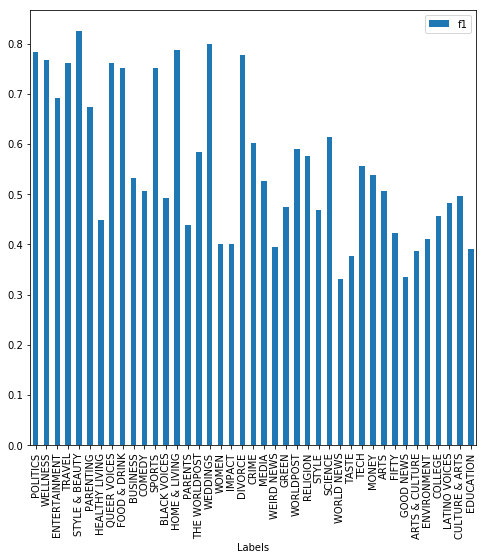

In [41]:
#Convert categoryCount to a Dataframe for merging
category_count = pd.DataFrame({'Labels': categoryCount.index, 'Count': categoryCount.values}) 

#Merge the f1 and category_count dataframes
f1_count_df = pd.merge(f1, category_count)

#Order the dataframe by the article count for plotting
f1_count_df = f1_count_df.sort_values(by='Count', ascending = False)

#Plot the f1 score, ordered from most to least prevalent categories
f1_count_df.plot(kind='bar', x ='Labels', y = 'f1', figsize=(8,8))

## Compare multiple model types

In [22]:
feature_reps = ['binary','counts','tfidf']
fields = ['desc_headline_url','text_desc_headline','short_description']


results = []
#Loop over fields and feature_reps, creating a model within each loop
for field in fields:
    for feature_rep in feature_reps:
        model, transformer, acc, f1 = train_model(df, field, feature_rep)
        logging.info("Model Completed")
        #Collapse f1 score
        f1 = sum(f1['f1'])/len(f1.index)
        results.append([field, feature_rep, acc, f1])

2020-04-19 14:33:05,262 : INFO : Starting model training...
2020-04-19 14:33:05,395 : INFO : Extracting features and creating vocabulary...
2020-04-19 14:33:14,041 : INFO : Training a Logistic Regression Model...


[LibLinear]

2020-04-19 14:39:59,912 : INFO : Model fit complete.
2020-04-19 14:39:59,982 : INFO : Starting Evaluation...
2020-04-19 14:40:00,522 : INFO : Done training and evaluation.
2020-04-19 14:40:00,560 : INFO : Model Completed
2020-04-19 14:40:00,561 : INFO : Starting model training...
2020-04-19 14:40:00,641 : INFO : Extracting features and creating vocabulary...
2020-04-19 14:40:10,106 : INFO : Training a Logistic Regression Model...


[LibLinear]

2020-04-19 14:49:27,057 : INFO : Model fit complete.
2020-04-19 14:49:27,138 : INFO : Starting Evaluation...
2020-04-19 14:49:27,580 : INFO : Done training and evaluation.
2020-04-19 14:49:27,627 : INFO : Model Completed
2020-04-19 14:49:27,628 : INFO : Starting model training...
2020-04-19 14:49:27,698 : INFO : Extracting features and creating vocabulary...
2020-04-19 14:49:27,698 : INFO : tfidf transformation
2020-04-19 14:49:36,974 : INFO : Training a Logistic Regression Model...


[LibLinear]

2020-04-19 14:51:21,294 : INFO : Model fit complete.
2020-04-19 14:51:21,356 : INFO : Starting Evaluation...
2020-04-19 14:51:21,828 : INFO : Done training and evaluation.
2020-04-19 14:51:21,864 : INFO : Model Completed
2020-04-19 14:51:21,865 : INFO : Starting model training...
2020-04-19 14:51:21,937 : INFO : Extracting features and creating vocabulary...
2020-04-19 14:51:28,634 : INFO : Training a Logistic Regression Model...


[LibLinear]

2020-04-19 14:57:01,024 : INFO : Model fit complete.
2020-04-19 14:57:01,081 : INFO : Starting Evaluation...
2020-04-19 14:57:01,527 : INFO : Done training and evaluation.
2020-04-19 14:57:01,574 : INFO : Model Completed
2020-04-19 14:57:01,575 : INFO : Starting model training...
2020-04-19 14:57:01,646 : INFO : Extracting features and creating vocabulary...
2020-04-19 14:57:08,289 : INFO : Training a Logistic Regression Model...


[LibLinear]

2020-04-19 15:06:20,073 : INFO : Model fit complete.
2020-04-19 15:06:20,148 : INFO : Starting Evaluation...
2020-04-19 15:06:20,648 : INFO : Done training and evaluation.
2020-04-19 15:06:20,690 : INFO : Model Completed
2020-04-19 15:06:20,691 : INFO : Starting model training...
2020-04-19 15:06:20,762 : INFO : Extracting features and creating vocabulary...
2020-04-19 15:06:20,762 : INFO : tfidf transformation
2020-04-19 15:06:27,996 : INFO : Training a Logistic Regression Model...


[LibLinear]

2020-04-19 15:08:03,591 : INFO : Model fit complete.
2020-04-19 15:08:03,651 : INFO : Starting Evaluation...
2020-04-19 15:08:04,258 : INFO : Done training and evaluation.
2020-04-19 15:08:04,286 : INFO : Model Completed
2020-04-19 15:08:04,287 : INFO : Starting model training...
2020-04-19 15:08:04,355 : INFO : Extracting features and creating vocabulary...
2020-04-19 15:08:09,074 : INFO : Training a Logistic Regression Model...


[LibLinear]

2020-04-19 15:14:09,704 : INFO : Model fit complete.
2020-04-19 15:14:09,761 : INFO : Starting Evaluation...
2020-04-19 15:14:10,288 : INFO : Done training and evaluation.
2020-04-19 15:14:10,327 : INFO : Model Completed
2020-04-19 15:14:10,329 : INFO : Starting model training...
2020-04-19 15:14:10,403 : INFO : Extracting features and creating vocabulary...
2020-04-19 15:14:15,248 : INFO : Training a Logistic Regression Model...


[LibLinear]

2020-04-19 15:23:04,527 : INFO : Model fit complete.
2020-04-19 15:23:04,577 : INFO : Starting Evaluation...
2020-04-19 15:23:05,077 : INFO : Done training and evaluation.
2020-04-19 15:23:05,118 : INFO : Model Completed
2020-04-19 15:23:05,119 : INFO : Starting model training...
2020-04-19 15:23:05,191 : INFO : Extracting features and creating vocabulary...
2020-04-19 15:23:05,192 : INFO : tfidf transformation
2020-04-19 15:23:10,279 : INFO : Training a Logistic Regression Model...


[LibLinear]

2020-04-19 15:24:38,409 : INFO : Model fit complete.
2020-04-19 15:24:38,461 : INFO : Starting Evaluation...
2020-04-19 15:24:39,136 : INFO : Done training and evaluation.
2020-04-19 15:24:39,163 : INFO : Model Completed


In [26]:
df_results = pd.DataFrame(results, columns = ['text_fields', 'feature_representation', 'accuracy', 'f1'])
df_results.sort_values(by= ['text_fields', 'accuracy'], ascending = False)

,text_fields,feature_representation,accuracy,f1
5,text_desc_headline,tfidf,0.614390,0.486546
3,text_desc_headline,binary,0.579679,0.460599
4,text_desc_headline,counts,0.575676,0.455655
8,short_description,tfidf,0.450970,0.298871
6,short_description,binary,0.416059,0.279908
7,short_description,counts,0.413550,0.278029
2,desc_headline_url,tfidf,0.667204,0.558007
1,desc_headline_url,counts,0.642669,0.540037
0,desc_headline_url,binary,0.642510,0.538860


### Model can be used on articles from different sources

In [44]:
#https://www.cnn.com/2020/04/18/politics/freshmen-democrats-crisis-coronavirus-congress-house/index.html
test_features = transformer.transform(["Baptized by fire and virus: How an historic freshmen class in Congress has been tested by constant crisis"])
model.predict(test_features)

array(['POLITICS'], dtype=object)

In [43]:
#https://www.cnn.com/2020/04/18/politics/cdc-coronavirus-testing-contamination/index.html
test_features = transformer.transform(["Contamination in manufacturing the Centers for Disease Control and Prevention test for the coronavirus caused weeks of delays that slowed the US response to the pandemic, multiple health officials have told CNN, a problem that stemmed in part from the CDC not adhering to its own protocols, according to a US Food and Drug Administration spokesperson."])
model.predict(test_features)

array(['WELLNESS'], dtype=object)

In [ ]:
def save_model(model, transformer):
    model_path="../models/model.pkl"
    transformer_path="../models/transformer.pkl"
    
    # we need to save both the transformer -> to encode a document and the model itself to make predictions based on the weight vectors 
    pickle.dump(model, open(model_path, 'wb'))
    pickle.dump(transformer, open(transformer_path,'wb'))
    
    return